<a href="https://colab.research.google.com/github/jadhav-rakesh/NLP/blob/main/text_generation_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade tensorflow

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import string
import numpy as np
import pandas as pd

In [3]:
!wget --no-check-certificate \
    https://drive.google.com/uc?id=1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8 \
    -O /tmp/songdata.csv

--2025-02-08 11:48:41--  https://drive.google.com/uc?id=1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8
Resolving drive.google.com (drive.google.com)... 74.125.68.101, 74.125.68.100, 74.125.68.139, ...
Connecting to drive.google.com (drive.google.com)|74.125.68.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8 [following]
--2025-02-08 11:48:41--  https://drive.usercontent.google.com/download?id=1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.10.132, 2404:6800:4003:c03::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.10.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 72436445 (69M) [application/octet-stream]
Saving to: ‘/tmp/songdata.csv’

/tmp/songdata.csv   100%[===================>]  69.08M  51.3MB/s    in 1.3s    

2025-02-08 11:48:48 (51.3 MB/s) 

In [4]:
def tokenize_corpus(corpus, num_words=-1):
    if num_words > -1:
        tokenizer = Tokenizer(num_words=num_words)
    else:
        tokenizer = Tokenizer()
    tokenizer.fit_on_texts(corpus)
    return tokenizer

def create_lyrics_corpus(dataset, field):
    dataset[field] = dataset[field].str.replace("[{}]".format(string.punctuation), "")
    dataset[field] = dataset[field].str.lower()
    lyrics = dataset[field].str.cat()
    corpus = lyrics.split("\n")
    for l in range(len(corpus)):
        corpus[l] = corpus[l].rstrip()
    corpus = [l for l in corpus if l != ""]
    return corpus

In [7]:
dataset = pd.read_csv('/tmp/songdata.csv', dtype=str)[:250]
corpus = create_lyrics_corpus(dataset, "text")
tokenizer = tokenize_corpus(corpus, num_words=2000)
total_words = tokenizer.num_words
print(total_words)

2000


In [8]:
sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i + 1]
        sequences.append(n_gram_sequence)

max_sequence_len = max([len(seq) for seq in sequences])
sequences = np.array(pad_sequences(sequences, maxlen=max_sequence_len, padding="pre"))

input_sequences, labels = sequences[:, :-1], sequences[:,-1]
one_hot_labels = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [9]:
print(tokenizer.word_index["know"])
print(tokenizer.word_index["feeling"])

print(input_sequences[5])
print(input_sequences[6])

print(one_hot_labels[5])
print(one_hot_labels[6])

31
160
[  0   0   0   0   0   0   0   0   0   0   0   0   0 112  65  83 211  32
   4]
[   0    0    0    0    0    0    0    0    0    0    0    0  112   65
   83  211   32    4 1204]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

model = Sequential()
model.add(Embedding(total_words, 64, input_length=max_sequence_len))
model.add(Bidirectional(LSTM(20)))
model.add(Dense(total_words, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(input_sequences, one_hot_labels, epochs=100, verbose=1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/100
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.0449 - loss: 6.2217
Epoch 2/100
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.0504 - loss: 5.6968
Epoch 3/100
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.0664 - loss: 5.4910
Epoch 4/100
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.0893 - loss: 5.3101
Epoch 5/100
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.1144 - loss: 5.1560
Epoch 6/100
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.1355 - loss: 4.9853
Epoch 7/100
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.1498 - loss: 4.8109
Epoch 8/100
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.1641 - loss: 4.6478
Epoch 9/100
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.1823 - loss: 4.4924
Epoch 10/100
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.1974 - loss: 4.3501
Epoch 11/100
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.2074 - loss: 4.2363
Epoch 12

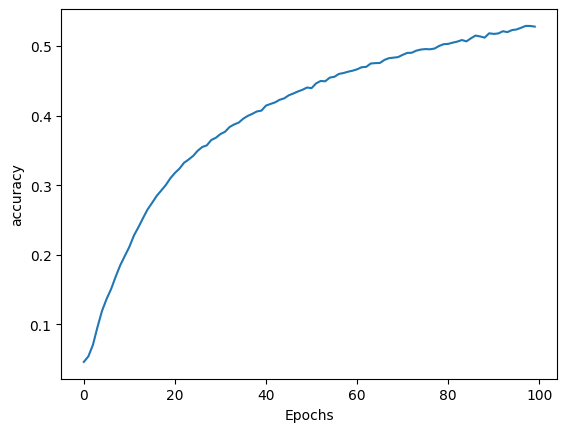

In [11]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.show()

plot_graphs(history, "accuracy")

In [12]:
seed_text = "i like purple"
next_words = 100

for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding="pre")
    predicted = np.argmax(model.predict(token_list), axis=-1)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            ouput_word = word
            break
    seed_text += " " + ouput_word
print(seed_text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━

In [13]:
seed_text = "i like purple"
next_words = 100

token_list = tokenizer.texts_to_sequences([seed_text])[0]
token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding="pre")
predicted_probs = model.predict(token_list)[0]
predicted = np.random.choice([x for x in range(len(predicted_probs))],
                             p=predicted_probs)
print(predicted)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
501


In [14]:
seed_text = "i like purple"
next_words = 100

for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding="pre")
    predicted_probs = model.predict(token_list)[0]
    predicted = np.random.choice([x for x in range(len(predicted_probs))],
                             p=predicted_probs)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            ouput_word = word
            break
    seed_text += " " + ouput_word
print(seed_text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━